**Link Dataset** : https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis

## Import Library

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from datetime import datetime, timedelta
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import h5py
import itertools
import networkx as nx
import pickle
import joblib
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Data Loading

In [2]:
# Load data
df = pd.read_excel('dataset/Assignment-1_Data.xlsx')
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Exploratory Data Analysis (EDA)

In [3]:
# Cek informasi umum
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      522064 non-null  object        
 1   Itemname    520609 non-null  object        
 2   Quantity    522064 non-null  int64         
 3   Date        522064 non-null  datetime64[ns]
 4   Price       522064 non-null  float64       
 5   CustomerID  388023 non-null  float64       
 6   Country     522064 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 27.9+ MB


In [4]:
# Statistik deskriptif
df.describe()

,Quantity,Date,Price,CustomerID
count,522064.000000,522064,522064.000000,388023.000000
mean,10.090435,2011-07-04 12:51:20.777107456,3.826801,15316.931710
min,-9600.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 10:15:00,1.250000,13950.000000
50%,3.000000,2011-07-20 08:59:00,2.080000,15265.000000
75%,10.000000,2011-10-19 14:12:00,4.130000,16837.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,161.110525,NaN,41.900599,1721.846964


In [5]:
# Cek missing values
df.isnull().sum()

BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134041
Country            0
dtype: int64

In [6]:
# Cek jumlah data duplikat
duplicate_count = df.duplicated().sum()
print(f"Jumlah baris duplikat: {duplicate_count}")

Jumlah baris duplikat: 5286


In [7]:
# Identifikasi Kolom Numerik dan Kategorikal
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nKolom Numerik: {num_cols}")
print(f"Kolom Kategorikal: {cat_cols}")


Kolom Numerik: ['Quantity', 'Price', 'CustomerID']
Kolom Kategorikal: ['BillNo', 'Itemname', 'Country']


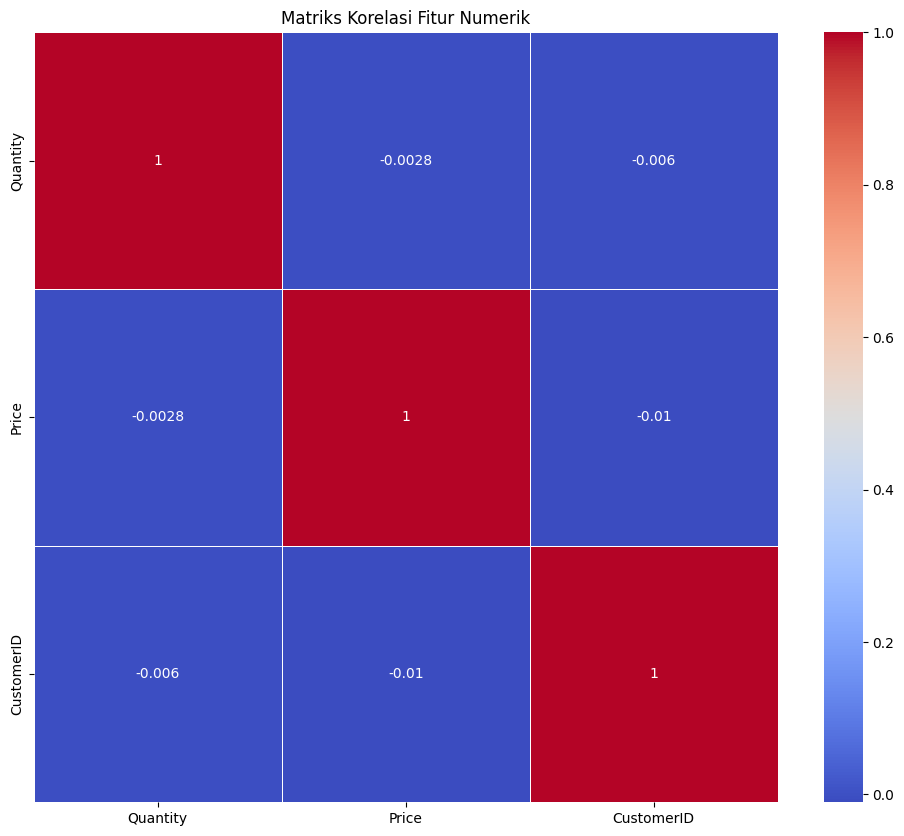

In [8]:
# Analisis Korelasi untuk Fitur Numerik
if len(num_cols) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[num_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Matriks Korelasi Fitur Numerik')
    plt.show()

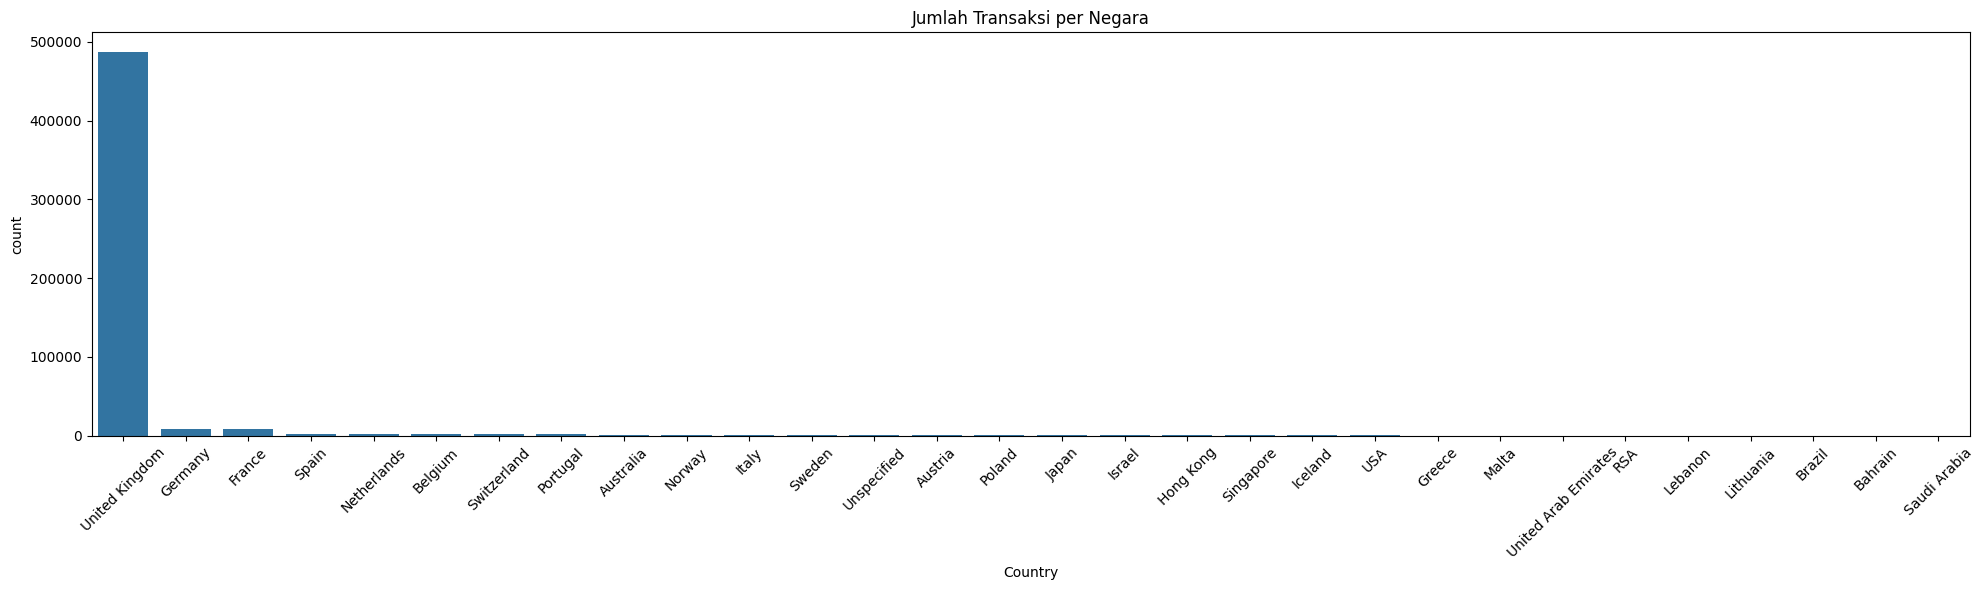

In [9]:
# Distribusi Transaksi per Negara
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='Country', order=df['Country'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Jumlah Transaksi per Negara')
plt.tight_layout()
plt.show()

In [10]:
# Atur supaya pandas tampilkan semua baris output
pd.set_option('display.max_rows', None)

print(df['Itemname'].value_counts())


Itemname
WHITE HANGING HEART T-LIGHT HOLDER      2269
JUMBO BAG RED RETROSPOT                 2087
REGENCY CAKESTAND 3 TIER                1930
PARTY BUNTING                           1677
LUNCH BAG RED RETROSPOT                 1570
ASSORTED COLOUR BIRD ORNAMENT           1465
SET OF 3 CAKE TINS PANTRY DESIGN        1360
PACK OF 72 RETROSPOT CAKE CASES         1328
LUNCH BAG  BLACK SKULL.                 1315
NATURAL SLATE HEART CHALKBOARD          1246
JUMBO BAG PINK POLKADOT                 1231
HEART OF WICKER SMALL                   1206
JUMBO STORAGE BAG SUKI                  1191
PAPER CHAIN KIT 50'S CHRISTMAS          1183
JUMBO SHOPPER VINTAGE RED PAISLEY       1181
LUNCH BAG SPACEBOY DESIGN               1169
LUNCH BAG CARS BLUE                     1156
SPOTTY BUNTING                          1133
JAM MAKING SET PRINTED                  1123
LUNCH BAG SUKI DESIGN                   1112
WOODEN PICTURE FRAME WHITE FINISH       1103
RECIPE BOX PANTRY YELLOW DESIGN         1101
L

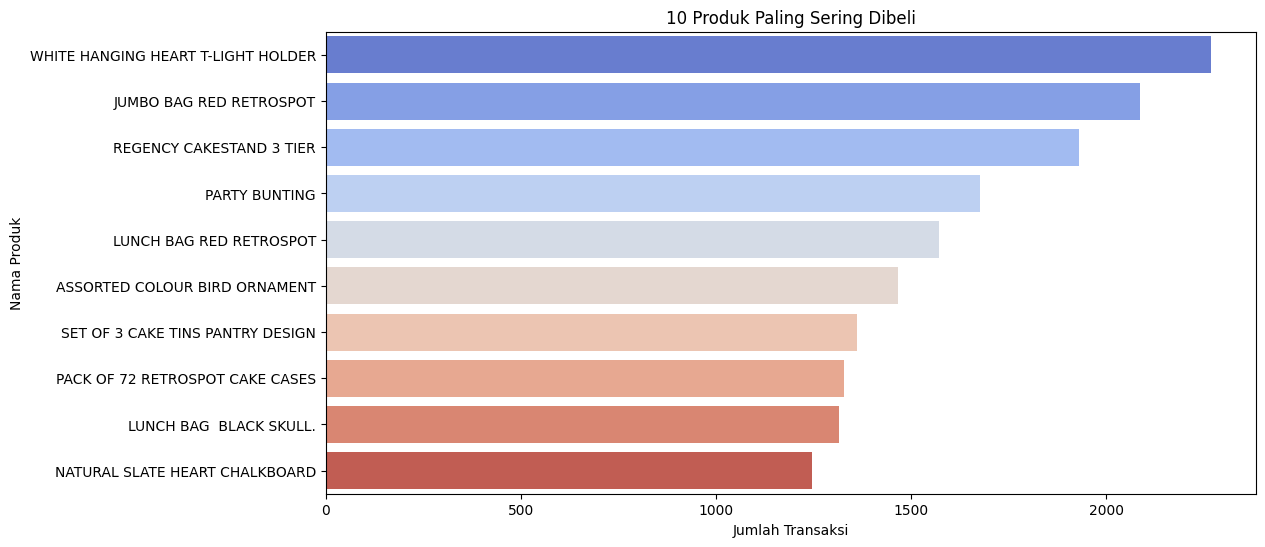

In [11]:
# 10 Produk Terpopuler
top_items = df['Itemname'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_items.values, y=top_items.index, palette='coolwarm')
plt.title('10 Produk Paling Sering Dibeli')
plt.xlabel('Jumlah Transaksi')
plt.ylabel('Nama Produk')
plt.show()

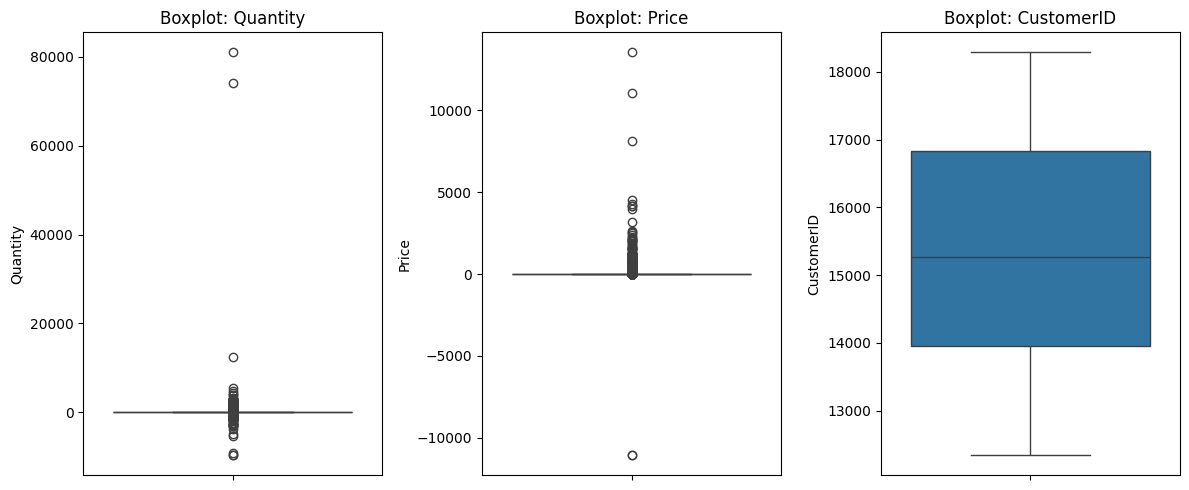

In [12]:
# Deteksi Outlier
plt.figure(figsize=(12, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

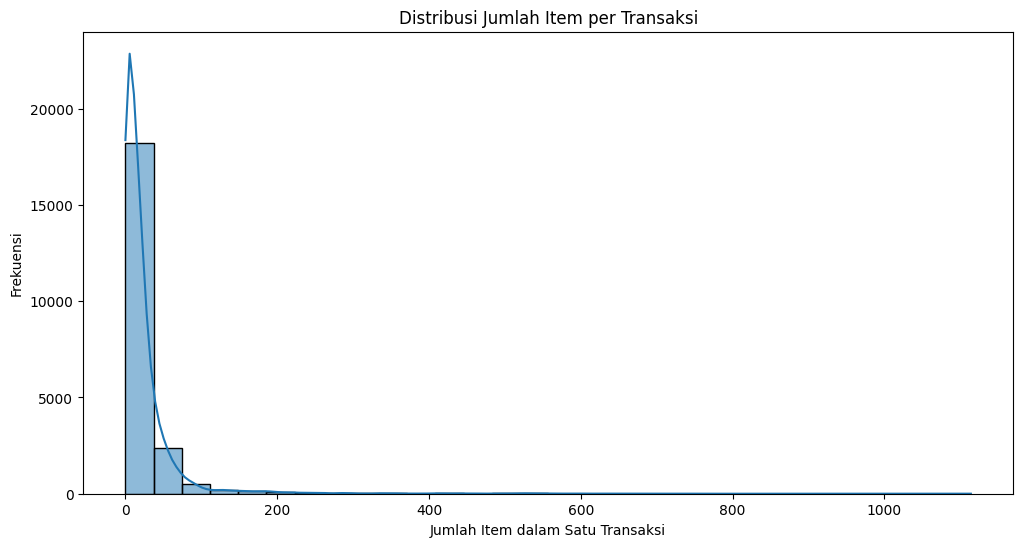

In [13]:
# Distribusi Jumlah Item dalam Transaksi
items_per_invoice = df.groupby('BillNo')['Itemname'].count()

plt.figure(figsize=(12, 6))
sns.histplot(items_per_invoice, bins=30, kde=True)
plt.title('Distribusi Jumlah Item per Transaksi')
plt.xlabel('Jumlah Item dalam Satu Transaksi')
plt.ylabel('Frekuensi')
plt.show()

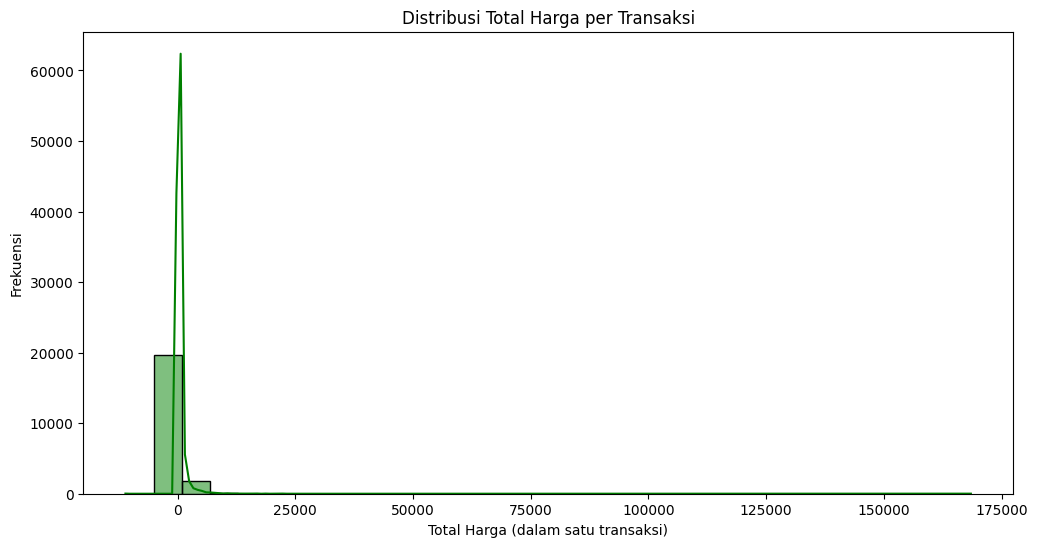

In [14]:
# Total Harga per Transaksi
df['TotalPrice'] = df['Quantity'] * df['Price']
revenue_per_invoice = df.groupby('BillNo')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
sns.histplot(revenue_per_invoice, bins=30, kde=True, color='green')
plt.title('Distribusi Total Harga per Transaksi')
plt.xlabel('Total Harga (dalam satu transaksi)')
plt.ylabel('Frekuensi')
plt.show()

### Data Preprocessing

In [15]:
# 1. Mengcopy dataframe untuk keamanan
data = df.copy()

In [16]:
# 2. Menghapus kolom
data = data.drop(columns=['CustomerID', 'Price', 'Quantity', 'Country', 'Date', 'TotalPrice'])

In [17]:
# 3. Menangani Missing value
data.dropna(inplace=True)
print("\nJumlah missing values Akhir")
print(data.isnull().sum())


Jumlah missing values Akhir
BillNo      0
Itemname    0
dtype: int64


In [18]:
# 4.Menghapus data duplikat
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())

0


In [19]:
# 5. Standardisasi nama produk  
data['Itemname'] = data['Itemname'].str.strip().str.upper()
print("Jumlah produk unik: {data['Itemname'].nunique()}")

Jumlah produk unik: {data['Itemname'].nunique()}


In [20]:
# 6. Gunakan pendekatan bertingkat
min_frequency_high = 10  # Untuk produk utama
min_frequency_low = 3    # Untuk produk pendukung

product_counts = data['Itemname'].value_counts()

# Buat dua kategori produk berdasarkan frekuensi
high_freq_products = product_counts[product_counts >= min_frequency_high].index
low_freq_products = product_counts[
    (product_counts >= min_frequency_low) & (product_counts < min_frequency_high)
].index

# Gabungkan keduanya untuk digunakan dalam analisis
all_valid_products = high_freq_products.union(low_freq_products)

# Filter data berdasarkan produk yang valid
data = data[data['Itemname'].isin(all_valid_products)]

print(f"Data setelah filter produk (min {min_frequency_low} kemunculan): {len(data)}")
print(f"Produk unik tersisa: {data['Itemname'].nunique()}")


Data setelah filter produk (min 3 kemunculan): 509226
Produk unik tersisa: 3720


In [21]:
# 7. Filter transaksi dengan item maksimal 50 (hapus bulk order)
transaction_sizes = data.groupby('BillNo').size()
valid_transactions = transaction_sizes[transaction_sizes <= 50].index
data = data[data['BillNo'].isin(valid_transactions)]

print(f"Data setelah filter transaksi outlier: {len(data)}")
print(f"Jumlah transaksi: {data['BillNo'].nunique()}")

Data setelah filter transaksi outlier: 274795
Jumlah transaksi: 18003


In [22]:
# Create pivot table (basket format)
pivot_table = pd.crosstab(data['BillNo'], data['Itemname'])
pivot_table = (pivot_table > 0).astype(int)

print(f"Pivot table shape: {pivot_table.shape}")
print(f"Sample pivot table:\n{pivot_table.head()}")

Pivot table shape: (18003, 3609)
Sample pivot table:
Itemname  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
BillNo                                                         
536365                         0                           0   
536366                         0                           0   
536367                         0                           0   
536368                         0                           0   
536369                         0                           0   

Itemname  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
BillNo                                                           
536365                            0                          0   
536366                            0                          0   
536367                            0                          0   
536368                            0                          0   
536369                            0                          0   

Itemname  12 HANGING EGGS HAND PAIN

In [24]:
# Generate frequent itemsets
print("Generating frequent itemsets...")
frequent_itemsets = apriori(pivot_table, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"Frequent itemsets found: {len(frequent_itemsets)}")
print("\nTop 10 frequent itemsets:")
print(frequent_itemsets.head(10))

Generating frequent itemsets...
Frequent itemsets found: 534

Top 10 frequent itemsets:
    support                               itemsets  length
0  0.010109               (10 COLOUR SPACEBOY PEN)       1
1  0.010943  (12 PENCILS SMALL TUBE RED RETROSPOT)       1
2  0.010832          (12 PENCILS SMALL TUBE SKULL)       1
3  0.014442     (3 HOOK PHOTO SHELF ANTIQUE WHITE)       1
4  0.011165   (3 PIECE SPACEBOY COOKIE CUTTER SET)       1
5  0.015220             (3 STRIPEY MICE FELTCRAFT)       1
6  0.014164          (4 TRADITIONAL SPINNING TOPS)       1
7  0.028662               (6 RIBBONS RUSTIC CHARM)       1
8  0.010109      (60 CAKE CASES DOLLY GIRL DESIGN)       1
9  0.017830      (60 CAKE CASES VINTAGE CHRISTMAS)       1


In [25]:
# Generate association rules
print("Generating association rules...")
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

print(f"Association rules found: {len(rules)}")
print("\nRules statistics:")
print(rules[['support', 'confidence', 'lift']].describe())

# Sort rules by confidence and lift
rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

Generating association rules...
Association rules found: 294

Rules statistics:
          support  confidence        lift
count  294.000000  294.000000  294.000000
mean     0.013126    0.414188   13.068458
std      0.003173    0.166413    7.868929
min      0.010054    0.120335    2.003936
25%      0.010943    0.298362    8.114989
50%      0.012054    0.379862   10.379826
75%      0.014692    0.528131   16.415208
max      0.027995    0.906907   52.447857


In [26]:
# Cross-selling recommendations (1 item -> 1 item)
cross_selling_rules = rules[
    (rules['antecedents'].apply(len) == 1) & 
    (rules['consequents'].apply(len) == 1)
].sort_values(by=['confidence', 'support'], ascending=False)

# Get top recommendations
top_cross_selling = cross_selling_rules.head(10)

print("=" * 50)
print("REKOMENDASI CROSS-SELLING (Top 10):")
print("=" * 50)
for idx, row in top_cross_selling.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequent = list(row['consequents'])[0]
    confidence = row['confidence']
    support = row['support']
    lift = row['lift']
    print(f"'{antecedent}' -> '{consequent}' (Confidence: {confidence:.3f}, Support: {support:.3f}, Lift: {lift:.3f})")

REKOMENDASI CROSS-SELLING (Top 10):
'PINK REGENCY TEACUP AND SAUCER' -> 'GREEN REGENCY TEACUP AND SAUCER' (Confidence: 0.809, Support: 0.020, Lift: 26.161)
'SET/6 RED SPOTTY PAPER CUPS' -> 'SET/6 RED SPOTTY PAPER PLATES' (Confidence: 0.784, Support: 0.011, Lift: 52.448)
'GREEN REGENCY TEACUP AND SAUCER' -> 'ROSES REGENCY TEACUP AND SAUCER' (Confidence: 0.754, Support: 0.023, Lift: 21.685)
'PAINTED METAL PEARS ASSORTED' -> 'ASSORTED COLOUR BIRD ORNAMENT' (Confidence: 0.749, Support: 0.011, Lift: 11.606)
'PINK REGENCY TEACUP AND SAUCER' -> 'ROSES REGENCY TEACUP AND SAUCER' (Confidence: 0.747, Support: 0.018, Lift: 21.472)
'WOODEN STAR CHRISTMAS SCANDINAVIAN' -> 'WOODEN HEART CHRISTMAS SCANDINAVIAN' (Confidence: 0.726, Support: 0.012, Lift: 42.976)
'BAKING SET SPACEBOY DESIGN' -> 'BAKING SET 9 PIECE RETROSPOT' (Confidence: 0.715, Support: 0.013, Lift: 20.200)
'SET/6 RED SPOTTY PAPER PLATES' -> 'SET/6 RED SPOTTY PAPER CUPS' (Confidence: 0.714, Support: 0.011, Lift: 52.448)
'GARDENERS KNEEL

In [27]:
# Upselling recommendations (1 item -> multiple items)
upselling_rules = rules[
    (rules['antecedents'].apply(len) == 1) & 
    (rules['consequents'].apply(len) > 1)
].sort_values(by=['confidence', 'support'], ascending=False)

# Get top recommendations
top_upselling = upselling_rules.head(10)

print("=" * 50)
print("REKOMENDASI UPSELLING (Top 10):")
print("=" * 50)
for idx, row in top_upselling.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequents = list(row['consequents'])
    confidence = row['confidence']
    support = row['support']
    lift = row['lift']
    print(f"'{antecedent}' -> {consequents} (Confidence: {confidence:.3f}, Support: {support:.3f}, Lift: {lift:.3f})")

REKOMENDASI UPSELLING (Top 10):
'PINK REGENCY TEACUP AND SAUCER' -> ['ROSES REGENCY TEACUP AND SAUCER', 'GREEN REGENCY TEACUP AND SAUCER'] (Confidence: 0.677, Support: 0.017, Lift: 29.025)
'GREEN REGENCY TEACUP AND SAUCER' -> ['ROSES REGENCY TEACUP AND SAUCER', 'PINK REGENCY TEACUP AND SAUCER'] (Confidence: 0.542, Support: 0.017, Lift: 29.312)
'ROSES REGENCY TEACUP AND SAUCER' -> ['GREEN REGENCY TEACUP AND SAUCER', 'PINK REGENCY TEACUP AND SAUCER'] (Confidence: 0.482, Support: 0.017, Lift: 24.059)
'PINK REGENCY TEACUP AND SAUCER' -> ['GREEN REGENCY TEACUP AND SAUCER', 'REGENCY CAKESTAND 3 TIER'] (Confidence: 0.448, Support: 0.011, Lift: 29.040)
'PINK REGENCY TEACUP AND SAUCER' -> ['ROSES REGENCY TEACUP AND SAUCER', 'REGENCY CAKESTAND 3 TIER'] (Confidence: 0.430, Support: 0.011, Lift: 25.327)
'ALARM CLOCK BAKELIKE PINK' -> ['ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE RED'] (Confidence: 0.413, Support: 0.010, Lift: 18.335)
'GREEN REGENCY TEACUP AND SAUCER' -> ['ROSES REGENCY TEAC

In [30]:
print("\n" + "="*60)
print("ENHANCED MARKET BASKET ANALYSIS SYSTEM - FIXED")
print("="*60)

# Enhanced Market Basket Analysis dengan Multiple Recommendation Strategies
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

class EnhancedMarketBasketRecommender:
    def __init__(self, data, min_support_primary=0.005, min_support_secondary=0.002, 
                 min_confidence=0.1, min_frequency_high=10, min_frequency_low=3):
        """
        Enhanced recommender dengan multiple strategies
        """
        self.data = data.copy()
        self.min_support_primary = min_support_primary
        self.min_support_secondary = min_support_secondary
        self.min_confidence = min_confidence
        self.min_frequency_high = min_frequency_high
        self.min_frequency_low = min_frequency_low
        
        # Initialize all recommendation engines
        self._prepare_data()
        self._build_association_rules()
        self._build_similarity_matrix()
        self._build_popularity_recommendations()
        
    def _prepare_data(self):
        """Prepare data dengan multiple frequency tiers"""
        # Standardisasi nama produk
        self.data['Itemname'] = self.data['Itemname'].str.strip().str.upper()
        
        # Hitung frekuensi produk
        product_counts = self.data['Itemname'].value_counts()
        
        # Kategorikan produk berdasarkan frekuensi
        self.high_freq_products = product_counts[product_counts >= self.min_frequency_high].index
        self.med_freq_products = product_counts[
            (product_counts >= self.min_frequency_low) & 
            (product_counts < self.min_frequency_high)
        ].index
        
        # FIX: Use Index.union() instead of pd.concat() for Index objects
        self.all_valid_products = self.high_freq_products.union(self.med_freq_products)
        
        # Filter data
        self.filtered_data = self.data[self.data['Itemname'].isin(self.all_valid_products)]
        
        # Create pivot table
        self.pivot_table = pd.crosstab(self.filtered_data['BillNo'], self.filtered_data['Itemname'])
        self.pivot_table = (self.pivot_table > 0).astype(int)
        
        print(f"High frequency products: {len(self.high_freq_products)}")
        print(f"Medium frequency products: {len(self.med_freq_products)}")
        print(f"Total valid products: {len(self.all_valid_products)}")
        
    def _build_association_rules(self):
        """Build association rules dengan multiple support levels"""
        try:
            # Primary rules (higher support)
            print("Building primary association rules...")
            frequent_itemsets_primary = apriori(
                self.pivot_table, 
                min_support=self.min_support_primary, 
                use_colnames=True
            )
            
            if len(frequent_itemsets_primary) > 0:
                self.primary_rules = association_rules(
                    frequent_itemsets_primary, 
                    metric="confidence", 
                    min_threshold=self.min_confidence
                )
            else:
                self.primary_rules = pd.DataFrame()
                
            # Secondary rules (lower support untuk produk jarang)
            print("Building secondary association rules...")
            frequent_itemsets_secondary = apriori(
                self.pivot_table, 
                min_support=self.min_support_secondary, 
                use_colnames=True
            )
            
            if len(frequent_itemsets_secondary) > 0:
                self.secondary_rules = association_rules(
                    frequent_itemsets_secondary, 
                    metric="confidence", 
                    min_threshold=max(0.05, self.min_confidence/2)  # Lower confidence untuk secondary
                )
            else:
                self.secondary_rules = pd.DataFrame()
                
            # Combine rules
            if len(self.primary_rules) > 0 and len(self.secondary_rules) > 0:
                self.all_rules = pd.concat([self.primary_rules, self.secondary_rules]).drop_duplicates()
            elif len(self.primary_rules) > 0:
                self.all_rules = self.primary_rules.copy()
            elif len(self.secondary_rules) > 0:
                self.all_rules = self.secondary_rules.copy()
            else:
                self.all_rules = pd.DataFrame()
            
            print(f"Primary rules: {len(self.primary_rules)}")
            print(f"Secondary rules: {len(self.secondary_rules)}")
            print(f"Total unique rules: {len(self.all_rules)}")
            
        except Exception as e:
            print(f"Error building association rules: {e}")
            self.primary_rules = pd.DataFrame()
            self.secondary_rules = pd.DataFrame()
            self.all_rules = pd.DataFrame()
    
    def _build_similarity_matrix(self):
        """Build item-item similarity matrix"""
        try:
            print("Building similarity matrix...")
            # Transpose untuk mendapat item-item similarity
            item_matrix = self.pivot_table.T
            
            # Hitung cosine similarity
            self.similarity_matrix = cosine_similarity(item_matrix)
            self.similarity_df = pd.DataFrame(
                self.similarity_matrix,
                index=item_matrix.index,
                columns=item_matrix.index
            )
            
            print(f"Similarity matrix shape: {self.similarity_matrix.shape}")
            
        except Exception as e:
            print(f"Error building similarity matrix: {e}")
            self.similarity_matrix = None
            self.similarity_df = None
    
    def _build_popularity_recommendations(self):
        """Build popularity-based recommendations untuk fallback"""
        self.popularity_scores = self.filtered_data['Itemname'].value_counts()
        self.popularity_dict = self.popularity_scores.to_dict()
        
        # Buat kategori produk berdasarkan popularitas
        total_products = len(self.popularity_scores)
        self.top_popular = self.popularity_scores.head(int(total_products * 0.2))  # Top 20%
        self.medium_popular = self.popularity_scores.iloc[
            int(total_products * 0.2):int(total_products * 0.6)
        ]  # Middle 40%
        
    def get_association_recommendations(self, item, top_n=5):
        """Get recommendations dari association rules"""
        recommendations = []
        
        if len(self.all_rules) == 0:
            return recommendations
            
        # Cari rules dimana item ada di antecedents
        for idx, row in self.all_rules.iterrows():
            antecedents = list(row['antecedents'])
            consequents = list(row['consequents'])
            
            if item in antecedents:
                for consequent in consequents:
                    if consequent != item:  # Jangan rekomendasikan item yang sama
                        recommendations.append({
                            'item': consequent,
                            'confidence': row['confidence'],
                            'support': row['support'],
                            'lift': row['lift'],
                            'method': 'association_rules'
                        })
        
        # Sort by confidence
        recommendations.sort(key=lambda x: x['confidence'], reverse=True)
        return recommendations[:top_n]
    
    def get_similarity_recommendations(self, item, top_n=5, min_similarity=0.1):
        """Get recommendations dari similarity matrix"""
        recommendations = []
        
        if self.similarity_df is None or item not in self.similarity_df.index:
            return recommendations
            
        # Get similarity scores untuk item
        similarities = self.similarity_df[item].sort_values(ascending=False)
        
        # Skip item itu sendiri dan ambil yang mirip
        for similar_item, similarity_score in similarities.iloc[1:].items():
            if similarity_score >= min_similarity:
                recommendations.append({
                    'item': similar_item,
                    'similarity_score': similarity_score,
                    'method': 'similarity_based'
                })
        
        return recommendations[:top_n]
    
    def get_category_recommendations(self, item, top_n=5):
        """Get recommendations berdasarkan kategori popularitas"""
        recommendations = []
        
        if item not in self.popularity_dict:
            return recommendations
            
        item_popularity = self.popularity_dict[item]
        
        # Tentukan kategori item
        if item in self.top_popular.index:
            # Untuk item populer, rekomendasikan item populer lainnya
            candidates = self.top_popular.drop(item, errors='ignore')
        else:
            # Untuk item kurang populer, rekomendasikan mix popular dan medium
            top_count = max(1, int(top_n * 0.7))
            med_count = max(1, int(top_n * 0.3))
            
            candidates = pd.concat([
                self.top_popular.head(top_count),
                self.medium_popular.head(med_count)
            ])
        
        for candidate_item, popularity_score in candidates.head(top_n).items():
            if candidate_item != item:
                recommendations.append({
                    'item': candidate_item,
                    'popularity_score': popularity_score,
                    'method': 'popularity_based'
                })
        
        return recommendations
    
    def get_comprehensive_recommendations(self, item, top_n=10):
        """Get comprehensive recommendations menggunakan semua metode"""
        all_recommendations = {}
        
        # 1. Association rules (prioritas tertinggi)
        assoc_recs = self.get_association_recommendations(item, top_n=top_n)
        for rec in assoc_recs:
            rec_item = rec['item']
            if rec_item not in all_recommendations:
                all_recommendations[rec_item] = {
                    'total_score': 0,
                    'methods': [],
                    'details': {}
                }
            
            # Weight association rules tertinggi
            score = rec['confidence'] * 3.0  # Weight = 3
            all_recommendations[rec_item]['total_score'] += score
            all_recommendations[rec_item]['methods'].append('association')
            all_recommendations[rec_item]['details']['association'] = rec
        
        # 2. Similarity-based recommendations
        sim_recs = self.get_similarity_recommendations(item, top_n=top_n)
        for rec in sim_recs:
            rec_item = rec['item']
            if rec_item not in all_recommendations:
                all_recommendations[rec_item] = {
                    'total_score': 0,
                    'methods': [],
                    'details': {}
                }
            
            # Weight similarity sedang
            score = rec['similarity_score'] * 2.0  # Weight = 2
            all_recommendations[rec_item]['total_score'] += score
            all_recommendations[rec_item]['methods'].append('similarity')
            all_recommendations[rec_item]['details']['similarity'] = rec
        
        # 3. Popularity-based (fallback)
        if len(all_recommendations) < top_n:
            pop_recs = self.get_category_recommendations(item, top_n=top_n*2)
            for rec in pop_recs:
                rec_item = rec['item']
                if rec_item not in all_recommendations:
                    all_recommendations[rec_item] = {
                        'total_score': 0,
                        'methods': [],
                        'details': {}
                    }
                
                # Weight popularity terendah
                max_pop = max(self.popularity_scores) if len(self.popularity_scores) > 0 else 1
                score = (rec['popularity_score'] / max_pop) * 1.0  # Weight = 1
                all_recommendations[rec_item]['total_score'] += score
                all_recommendations[rec_item]['methods'].append('popularity')
                all_recommendations[rec_item]['details']['popularity'] = rec
        
        # Sort by total score
        sorted_recommendations = sorted(
            all_recommendations.items(),
            key=lambda x: x[1]['total_score'],
            reverse=True
        )
        
        # Format output
        final_recommendations = []
        for item_name, data in sorted_recommendations[:top_n]:
            final_recommendations.append({
                'recommended_item': item_name,
                'total_score': data['total_score'],
                'methods_used': data['methods'],
                'method_details': data['details']
            })
        
        return final_recommendations
    
    def analyze_coverage(self):
        """Analyze recommendation coverage"""
        coverage_stats = {
            'total_products': len(self.all_valid_products),
            'products_with_association_rules': 0,
            'products_with_similarity': 0,
            'products_with_popularity_fallback': 0,
            'products_with_no_recommendations': 0
        }
        
        no_rec_products = []
        
        for product in self.all_valid_products:
            assoc_recs = self.get_association_recommendations(product, top_n=1)
            sim_recs = self.get_similarity_recommendations(product, top_n=1)
            pop_recs = self.get_category_recommendations(product, top_n=1)
            
            has_assoc = len(assoc_recs) > 0
            has_sim = len(sim_recs) > 0
            has_pop = len(pop_recs) > 0
            
            if has_assoc:
                coverage_stats['products_with_association_rules'] += 1
            if has_sim:
                coverage_stats['products_with_similarity'] += 1
            if has_pop:
                coverage_stats['products_with_popularity_fallback'] += 1
            
            if not (has_assoc or has_sim or has_pop):
                coverage_stats['products_with_no_recommendations'] += 1
                no_rec_products.append(product)
        
        if coverage_stats['total_products'] > 0:
            coverage_stats['coverage_percentage'] = (
                (coverage_stats['total_products'] - coverage_stats['products_with_no_recommendations']) 
                / coverage_stats['total_products'] * 100
            )
        else:
            coverage_stats['coverage_percentage'] = 0
        
        return coverage_stats, no_rec_products

print("Enhanced Market Basket Recommender System Class Defined!")

# ============================================================================
# FUNCTIONS FOR IMPLEMENTATION
# ============================================================================

def create_enhanced_recommender(data, **kwargs):
    """Helper function to create recommender with error handling"""
    try:
        # Default parameters
        default_params = {
            'min_support_primary': 0.01,
            'min_support_secondary': 0.001,
            'min_confidence': 0.08,
            'min_frequency_high': 8,
            'min_frequency_low': 2
        }
        
        # Update with user parameters
        default_params.update(kwargs)
        
        print("Creating Enhanced Market Basket Recommender...")
        recommender = EnhancedMarketBasketRecommender(data=data, **default_params)
        
        return recommender
        
    except Exception as e:
        print(f"Error creating recommender: {e}")
        return None

def get_product_recommendations_api(product_name, recommender, top_n=10):
    """API function untuk mendapatkan rekomendasi produk"""
    
    try:
        # Standardisasi nama produk
        product_name = product_name.strip().upper()
        
        # Cek apakah produk ada
        if product_name not in recommender.all_valid_products:
            return {
                'status': 'error',
                'message': f'Produk "{product_name}" tidak ditemukan',
                'recommendations': []
            }
        
        # Get recommendations
        recommendations = recommender.get_comprehensive_recommendations(product_name, top_n=top_n)
        
        # Format untuk API response
        formatted_recs = []
        for rec in recommendations:
            formatted_recs.append({
                'product_name': rec['recommended_item'],
                'recommendation_score': round(rec['total_score'], 3),
                'recommendation_methods': rec['methods_used'],
                'confidence_level': 'high' if 'association' in rec['methods_used'] else 
                                  'medium' if 'similarity' in rec['methods_used'] else 'low'
            })
        
        return {
            'status': 'success',
            'product': product_name,
            'total_recommendations': len(formatted_recs),
            'recommendations': formatted_recs
        }
        
    except Exception as e:
        return {
            'status': 'error',
            'message': str(e),
            'recommendations': []
        }

def update_recommendations_periodically(data, existing_recommender=None):
    """Update model dengan data terbaru"""
    
    print("UPDATING RECOMMENDATIONS...")
    
    # Buat recommender baru atau update yang ada
    new_recommender = create_enhanced_recommender(
        data=data,
        min_support_primary=0.003,
        min_support_secondary=0.001,
        min_confidence=0.08,
        min_frequency_high=8,
        min_frequency_low=2
    )
    
    if new_recommender:
        # Analisis improvement
        coverage_stats, _ = new_recommender.analyze_coverage()
        print(f"Updated coverage: {coverage_stats['coverage_percentage']:.2f}%")
        
        return new_recommender
    else:
        print("Failed to create updated recommender")
        return existing_recommender

print("Enhanced Market Basket Analysis System - READY TO USE!")
print("\nTo use this system:")
print("1. enhanced_recommender = create_enhanced_recommender(your_data)")
print("2. recommendations = enhanced_recommender.get_comprehensive_recommendations('PRODUCT_NAME')")
print("3. api_result = get_product_recommendations_api('PRODUCT_NAME', enhanced_recommender)")


ENHANCED MARKET BASKET ANALYSIS SYSTEM - FIXED
Enhanced Market Basket Recommender System Class Defined!
Enhanced Market Basket Analysis System - READY TO USE!

To use this system:
1. enhanced_recommender = create_enhanced_recommender(your_data)
2. recommendations = enhanced_recommender.get_comprehensive_recommendations('PRODUCT_NAME')
3. api_result = get_product_recommendations_api('PRODUCT_NAME', enhanced_recommender)


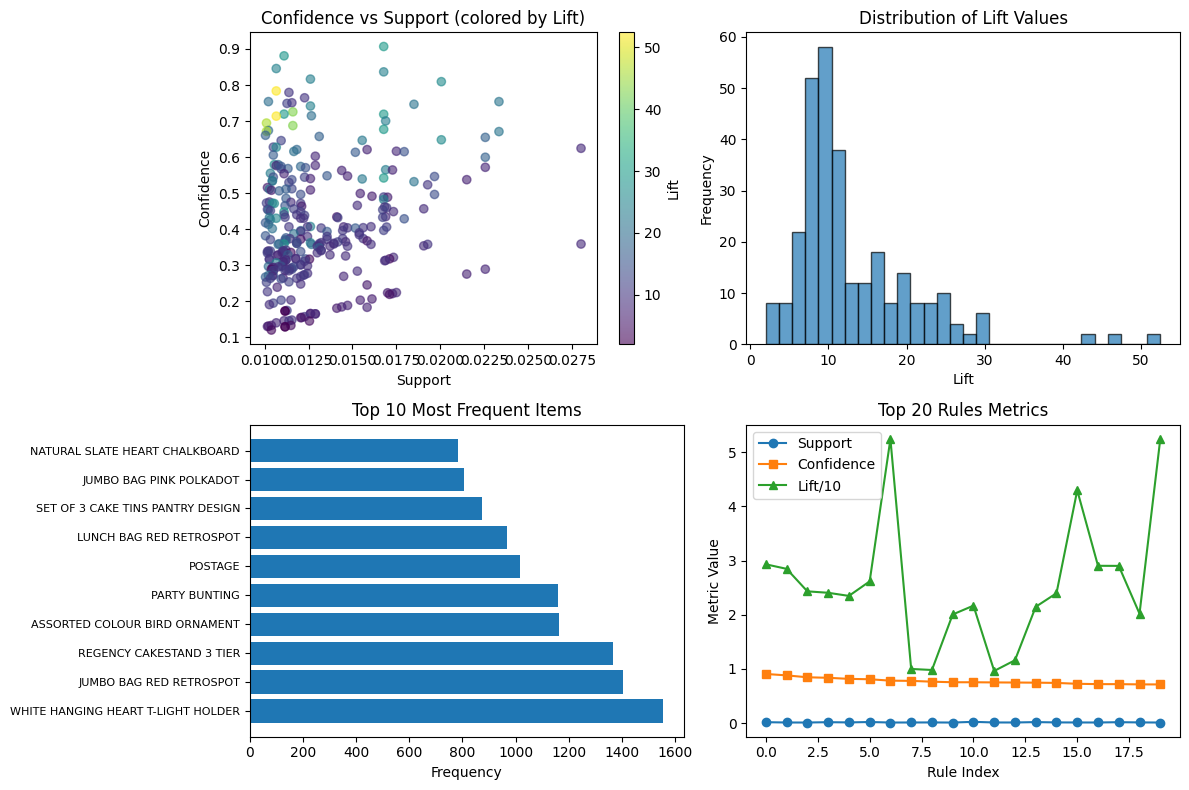

In [31]:
plt.figure(figsize=(12, 8))

# Plot 1: Confidence vs Support
plt.subplot(2, 2, 1)
plt.scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap='viridis')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Confidence vs Support (colored by Lift)')
plt.colorbar(label='Lift')

# Plot 2: Lift distribution
plt.subplot(2, 2, 2)
plt.hist(rules['lift'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.title('Distribution of Lift Values')

# Plot 3: Top items frequency
plt.subplot(2, 2, 3)
top_items = data['Itemname'].value_counts().head(10)
plt.barh(range(len(top_items)), top_items.values)
plt.yticks(range(len(top_items)), top_items.index, fontsize=8)
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Items')

# Plot 4: Rules metrics comparison
plt.subplot(2, 2, 4)
metrics_data = rules[['support', 'confidence', 'lift']].head(20)
x = range(len(metrics_data))
plt.plot(x, metrics_data['support'], label='Support', marker='o')
plt.plot(x, metrics_data['confidence'], label='Confidence', marker='s')
plt.plot(x, metrics_data['lift']/10, label='Lift/10', marker='^')
plt.xlabel('Rule Index')
plt.ylabel('Metric Value')
plt.title('Top 20 Rules Metrics')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
def save_market_basket_model_h5(filename='market_basket_model.h5'):
    """
    Save complete market basket analysis model in H5 format
    Following TensorFlow/Keras-like structure for ML model compatibility
    """
    
    with h5py.File(filename, 'w') as f:
        
        # ===== MODEL METADATA =====
        metadata_group = f.create_group('model_metadata')
        metadata_group.attrs['model_type'] = 'market_basket_analysis'
        metadata_group.attrs['algorithm'] = 'apriori_association_rules'
        metadata_group.attrs['created_at'] = datetime.now().isoformat()
        metadata_group.attrs['total_transactions'] = len(pivot_table)
        metadata_group.attrs['total_unique_items'] = len(all_valid_products)
        metadata_group.attrs['total_frequent_itemsets'] = len(frequent_itemsets)
        metadata_group.attrs['total_association_rules'] = len(rules)
        metadata_group.attrs['min_support_threshold'] = 0.015
        metadata_group.attrs['min_confidence_threshold'] = 0.2
        metadata_group.attrs['framework_version'] = 'mlxtend'
        
        # ===== FREQUENT ITEMSETS =====
        freq_group = f.create_group('frequent_itemsets')
        
        # Convert itemsets to string representation for storage
        itemsets_str = [str(list(itemset)) for itemset in frequent_itemsets['itemsets']]
        freq_group.create_dataset('itemsets', 
                                data=[s.encode('utf-8') for s in itemsets_str],
                                dtype=h5py.string_dtype(encoding='utf-8'))
        freq_group.create_dataset('support', data=frequent_itemsets['support'].values)
        freq_group.create_dataset('length', data=frequent_itemsets['length'].values)
        
        # ===== ASSOCIATION RULES =====
        rules_group = f.create_group('association_rules')
        
        # Convert frozensets to string for storage
        antecedents_str = [str(list(ant)) for ant in rules['antecedents']]
        consequents_str = [str(list(cons)) for cons in rules['consequents']]
        
        rules_group.create_dataset('antecedents',
                                 data=[s.encode('utf-8') for s in antecedents_str],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        rules_group.create_dataset('consequents',
                                 data=[s.encode('utf-8') for s in consequents_str],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        rules_group.create_dataset('support', data=rules['support'].values)
        rules_group.create_dataset('confidence', data=rules['confidence'].values)
        rules_group.create_dataset('lift', data=rules['lift'].values)
        rules_group.create_dataset('leverage', data=rules['leverage'].values)
        rules_group.create_dataset('conviction', data=rules['conviction'].values)
        
        # ===== CROSS-SELLING RULES =====
        cross_group = f.create_group('cross_selling_rules')
        if len(cross_selling_rules) > 0:
            cross_antecedents_str = [str(list(ant)) for ant in cross_selling_rules['antecedents']]
            cross_consequents_str = [str(list(cons)) for cons in cross_selling_rules['consequents']]
            
            cross_group.create_dataset('antecedents',
                                     data=[s.encode('utf-8') for s in cross_antecedents_str],
                                     dtype=h5py.string_dtype(encoding='utf-8'))
            cross_group.create_dataset('consequents',
                                     data=[s.encode('utf-8') for s in cross_consequents_str],
                                     dtype=h5py.string_dtype(encoding='utf-8'))
            cross_group.create_dataset('support', data=cross_selling_rules['support'].values)
            cross_group.create_dataset('confidence', data=cross_selling_rules['confidence'].values)
            cross_group.create_dataset('lift', data=cross_selling_rules['lift'].values)
        
        # ===== UPSELLING RULES =====
        up_group = f.create_group('upselling_rules')
        if len(upselling_rules) > 0:
            up_antecedents_str = [str(list(ant)) for ant in upselling_rules['antecedents']]
            up_consequents_str = [str(list(cons)) for cons in upselling_rules['consequents']]
            
            up_group.create_dataset('antecedents',
                                  data=[s.encode('utf-8') for s in up_antecedents_str],
                                  dtype=h5py.string_dtype(encoding='utf-8'))
            up_group.create_dataset('consequents',
                                  data=[s.encode('utf-8') for s in up_consequents_str],
                                  dtype=h5py.string_dtype(encoding='utf-8'))
            up_group.create_dataset('support', data=upselling_rules['support'].values)
            up_group.create_dataset('confidence', data=upselling_rules['confidence'].values)
            up_group.create_dataset('lift', data=upselling_rules['lift'].values)
        
        # ===== ITEM STATISTICS =====
        items_group = f.create_group('item_statistics')
        
        # Top items with their frequencies
        top_items_dict = data['Itemname'].value_counts().head(100).to_dict()
        item_names = list(top_items_dict.keys())
        item_counts = list(top_items_dict.values())
        
        items_group.create_dataset('item_names',
                                 data=[name.encode('utf-8') for name in item_names],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        items_group.create_dataset('item_frequencies', data=item_counts)
        
        # All unique items for reference
        all_items = list(all_valid_products)
        items_group.create_dataset('all_items',
                                 data=[item.encode('utf-8') for item in all_items],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        
        # ===== PIVOT TABLE STRUCTURE =====
        pivot_group = f.create_group('pivot_table_info')
        pivot_group.attrs['n_transactions'] = pivot_table.shape[0]
        pivot_group.attrs['n_items'] = pivot_table.shape[1]
        
        # Store column names (item names)
        pivot_columns = list(pivot_table.columns)
        pivot_group.create_dataset('column_names',
                                 data=[col.encode('utf-8') for col in pivot_columns],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        
        # ===== MODEL PERFORMANCE METRICS =====
        perf_group = f.create_group('performance_metrics')
        perf_group.attrs['avg_support'] = float(rules['support'].mean())
        perf_group.attrs['avg_confidence'] = float(rules['confidence'].mean())
        perf_group.attrs['avg_lift'] = float(rules['lift'].mean())
        perf_group.attrs['max_support'] = float(rules['support'].max())
        perf_group.attrs['max_confidence'] = float(rules['confidence'].max())
        perf_group.attrs['max_lift'] = float(rules['lift'].max())
        perf_group.attrs['min_support'] = float(rules['support'].min())
        perf_group.attrs['min_confidence'] = float(rules['confidence'].min())
        perf_group.attrs['min_lift'] = float(rules['lift'].min())

print("Function save_market_basket_model_h5 defined successfully!")

Function save_market_basket_model_h5 defined successfully!


In [ ]:
# Save the model
print("=" * 50)
print("SAVING MODEL IN H5 FORMAT FOR BACKEND")
print("=" * 50)

save_market_basket_model_h5('market_basket.h5')
print("✓ Model berhasil disimpan dalam format H5: 'market_basket.h5'")

SAVING MODEL IN H5 FORMAT FOR BACKEND
✓ Model berhasil disimpan dalam format H5: 'market_basket_model.h5'


In [36]:
class H5MarketBasketRecommender:
    """
    Market Basket Recommender yang menggunakan model H5
    Kompatibel dengan arsitektur TensorFlow/Keras untuk ML pipeline
    """
    
    def __init__(self, h5_model_path):
        """Load model dari file H5"""
        self.model_path = h5_model_path
        self.load_model()
    
    def load_model(self):
        """Load semua komponen model dari H5 file"""
        with h5py.File(self.model_path, 'r') as f:
            
            # Load metadata
            self.metadata = dict(f['model_metadata'].attrs)
            
            # Load frequent itemsets
            if 'frequent_itemsets' in f:
                freq_group = f['frequent_itemsets']
                self.frequent_itemsets = {
                    'itemsets': [eval(s.decode('utf-8')) for s in freq_group['itemsets'][:]],
                    'support': freq_group['support'][:],
                    'length': freq_group['length'][:]
                }
            
            # Load association rules
            if 'association_rules' in f:
                rules_group = f['association_rules']
                self.association_rules = {
                    'antecedents': [eval(s.decode('utf-8')) for s in rules_group['antecedents'][:]],
                    'consequents': [eval(s.decode('utf-8')) for s in rules_group['consequents'][:]],
                    'support': rules_group['support'][:],
                    'confidence': rules_group['confidence'][:],
                    'lift': rules_group['lift'][:]
                }
            
            # Load cross-selling rules
            if 'cross_selling_rules' in f and len(f['cross_selling_rules'].keys()) > 0:
                cross_group = f['cross_selling_rules']
                self.cross_selling_rules = {
                    'antecedents': [eval(s.decode('utf-8')) for s in cross_group['antecedents'][:]],
                    'consequents': [eval(s.decode('utf-8')) for s in cross_group['consequents'][:]],
                    'support': cross_group['support'][:],
                    'confidence': cross_group['confidence'][:],
                    'lift': cross_group['lift'][:]
                }
            else:
                self.cross_selling_rules = None
            
            # Load upselling rules
            if 'upselling_rules' in f and len(f['upselling_rules'].keys()) > 0:
                up_group = f['upselling_rules']
                self.upselling_rules = {
                    'antecedents': [eval(s.decode('utf-8')) for s in up_group['antecedents'][:]],
                    'consequents': [eval(s.decode('utf-8')) for s in up_group['consequents'][:]],
                    'support': up_group['support'][:],
                    'confidence': up_group['confidence'][:],
                    'lift': up_group['lift'][:]
                }
            else:
                self.upselling_rules = None
            
            # Load item statistics
            if 'item_statistics' in f:
                items_group = f['item_statistics']
                self.item_names = [s.decode('utf-8') for s in items_group['item_names'][:]]
                self.item_frequencies = items_group['item_frequencies'][:]
                self.all_items = [s.decode('utf-8') for s in items_group['all_items'][:]]
            
            # Load performance metrics
            if 'performance_metrics' in f:
                self.performance_metrics = dict(f['performance_metrics'].attrs)
    
    def get_cross_selling_recommendations(self, item, top_n=5, min_confidence=0.3):
        """Dapatkan rekomendasi cross-selling untuk item tertentu"""
        if not self.cross_selling_rules:
            return []
        
        recommendations = []
        
        for i, antecedent in enumerate(self.cross_selling_rules['antecedents']):
            if item in antecedent and self.cross_selling_rules['confidence'][i] >= min_confidence:
                consequent = self.cross_selling_rules['consequents'][i]
                if len(consequent) == 1:  # Cross-selling: 1 -> 1
                    recommendations.append({
                        'recommended_item': consequent[0],
                        'confidence': float(self.cross_selling_rules['confidence'][i]),
                        'support': float(self.cross_selling_rules['support'][i]),
                        'lift': float(self.cross_selling_rules['lift'][i]),
                        'rule_strength': 'cross_selling'
                    })
        
        # Sort by confidence and return top N
        recommendations.sort(key=lambda x: x['confidence'], reverse=True)
        return recommendations[:top_n]
    
    def get_upselling_recommendations(self, item, top_n=5, min_confidence=0.25):
        """Dapatkan rekomendasi upselling untuk item tertentu"""
        if not self.upselling_rules:
            return []
        
        recommendations = []
        
        for i, antecedent in enumerate(self.upselling_rules['antecedents']):
            if item in antecedent and self.upselling_rules['confidence'][i] >= min_confidence:
                consequents = self.upselling_rules['consequents'][i]
                recommendations.append({
                    'recommended_items': consequents,
                    'confidence': float(self.upselling_rules['confidence'][i]),
                    'support': float(self.upselling_rules['support'][i]),
                    'lift': float(self.upselling_rules['lift'][i]),
                    'rule_strength': 'upselling',
                    'bundle_size': len(consequents)
                })
        
        # Sort by confidence and return top N
        recommendations.sort(key=lambda x: x['confidence'], reverse=True)
        return recommendations[:top_n]
    
    def get_basket_recommendations(self, basket_items, top_n=10, min_confidence=0.2):
        """Rekomendasi berdasarkan keranjang belanja saat ini"""
        all_recommendations = {}
        
        for item in basket_items:
            if item in self.all_items:
                # Get cross-selling recommendations
                cross_recs = self.get_cross_selling_recommendations(item, top_n=20, min_confidence=min_confidence)
                
                for rec in cross_recs:
                    rec_item = rec['recommended_item']
                    if rec_item not in basket_items:  # Jangan rekomendasikan item yang sudah ada
                        if rec_item not in all_recommendations:
                            all_recommendations[rec_item] = {
                                'total_confidence': 0,
                                'total_support': 0,
                                'total_lift': 0,
                                'rule_count': 0,
                                'supporting_items': []
                            }
                        
                        all_recommendations[rec_item]['total_confidence'] += rec['confidence']
                        all_recommendations[rec_item]['total_support'] += rec['support']
                        all_recommendations[rec_item]['total_lift'] += rec['lift']
                        all_recommendations[rec_item]['rule_count'] += 1
                        all_recommendations[rec_item]['supporting_items'].append(item)
        
        # Calculate averages and create final recommendations
        final_recommendations = []
        for item, stats in all_recommendations.items():
            if stats['rule_count'] > 0:
                final_recommendations.append({
                    'recommended_item': item,
                    'avg_confidence': stats['total_confidence'] / stats['rule_count'],
                    'avg_support': stats['total_support'] / stats['rule_count'],
                    'avg_lift': stats['total_lift'] / stats['rule_count'],
                    'supporting_rules': stats['rule_count'],
                    'supporting_items': stats['supporting_items']
                })
        
        # Sort by average confidence
        final_recommendations.sort(key=lambda x: x['avg_confidence'], reverse=True)
        return final_recommendations[:top_n]
    
    def get_model_info(self):
        """Informasi model dan performa"""
        return {
            'model_metadata': self.metadata,
            'performance_metrics': self.performance_metrics if hasattr(self, 'performance_metrics') else {},
            'total_items': len(self.all_items) if hasattr(self, 'all_items') else 0,
            'top_items': dict(zip(self.item_names[:10], self.item_frequencies[:10])) if hasattr(self, 'item_names') else {}
        }

print("H5MarketBasketRecommender class defined successfully!")

H5MarketBasketRecommender class defined successfully!


In [37]:
print("=" * 50)
print("TESTING H5 MODEL LOADER")
print("=" * 50)

# Initialize H5 recommender
h5_recommender = H5MarketBasketRecommender('market_basket_model.h5')

# Get model info
model_info = h5_recommender.get_model_info()
print("Model Information:")
print(f"- Total items: {model_info['total_items']}")
print(f"- Model created: {model_info['model_metadata']['created_at']}")
print(f"- Total rules: {model_info['model_metadata']['total_association_rules']}")

TESTING H5 MODEL LOADER
Model Information:
- Total items: 3529
- Model created: 2025-06-09T20:31:50.977340
- Total rules: 69


In [38]:
# Basket recommendations
if hasattr(h5_recommender, 'item_names') and len(h5_recommender.item_names) > 1:
    test_basket = [h5_recommender.item_names[0]]
    if len(h5_recommender.item_names) > 1:
        test_basket.append(h5_recommender.item_names[1])
    
    print(f"Testing dengan basket: {test_basket}")
    basket_recs = h5_recommender.get_basket_recommendations(test_basket, top_n=5)
    print(f"Basket recommendations:")
    for rec in basket_recs:
        print(f"  - {rec['recommended_item']} (Avg Confidence: {rec['avg_confidence']:.3f}, Rules: {rec['supporting_rules']})")

Testing dengan basket: ['WHITE HANGING HEART T-LIGHT HOLDER', 'JUMBO BAG RED RETROSPOT']
Basket recommendations:
  - JUMBO BAG PINK POLKADOT (Avg Confidence: 0.359, Rules: 1)
  - JUMBO STORAGE BAG SUKI (Avg Confidence: 0.289, Rules: 1)
  - JUMBO SHOPPER VINTAGE RED PAISLEY (Avg Confidence: 0.276, Rules: 1)
  - JUMBO BAG STRAWBERRY (Avg Confidence: 0.224, Rules: 1)
  - JUMBO  BAG BAROQUE BLACK WHITE (Avg Confidence: 0.222, Rules: 1)
